In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/skhatta/anaconda3/lib/python3.11/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [2]:
import keras
from tensorflow.keras.applications import EfficientNetB0 #DenseNet121, DenseNet169, DenseNet201, ResNet50
from keras.models import Model
from keras.layers import Dense
from keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
# from label2onehot import label2onehot
# from onehot2label import onehot2label
# from label_dict import label_dict
import gc
tf.disable_v2_behavior()

2023-11-25 21:42:26.967035: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 21:42:27.041706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 21:42:27.041759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 21:42:27.044444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 21:42:27.056684: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 21:42:27.057803: I tensorflow/core/platform/cpu_feature_guard.cc:1

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
#Use GPU
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4}, log_device_placement=True ) 
sess = tf.Session(config=config) 
# keras.backend.set_session(sess)

Device mapping: no known devices.


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4884592452587674937
xla_global_id: -1
]


In [6]:
#Import train set
x = np.load('../../../Npy_Data//train_crop.npy',allow_pickle=True)/255.0
y_label = np.load('../../../Npy_Data/train.npy',allow_pickle=True)

In [7]:
#Convert label to onehot
#onehot_y = label2onehot(y[:, 0], 256)
#np.save('onehot_y_train.npy',onehot_y)
#from keras.utils.np_utils import to_categorical
#y = to_categorical(y_label[:,0], num_classes=256)
y = y_label[:,0]

In [8]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    return lr

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [30]:
from tensorflow.keras import regularizers
#Build the new model based on DenseNet121
def getmodel(num_classes=256):
    '''
    Build the new model based on DenseNet121, DenseNet169, DenseNet201
    
    Argument:
    num_classes -- (int) number of classes
    
    Return:
    model -- the new compiled model
    '''
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    orig_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x, drop_connect_rate = 0.4, classes=num_classes)
    
    # Freeze the pretrained weights
    orig_model.trainable = False
    
#     densenet_out = orig_model.layers[-1].output
#     out = Dense(256, activation='softmax', kernel_initializer='glorot_uniform')(densenet_out)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(orig_model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss= "sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

In [28]:
# import sys
# import logging

# so = open("data.log", 'w', 10)
# sys.stdout.echo = so
# sys.stderr.echo = so

# get_ipython().log.handlers[0].stream = so
# get_ipython().log.setLevel(logging.INFO)

In [ ]:
lr_callback = LearningRateScheduler(lr_schedule)
densemodel = getmodel(256)
# checkpoint
from keras.callbacks import ModelCheckpoint
filepath="EfficientNetB0_transfer_crop.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max',save_weights_only=True)
callbacks_list = [checkpoint]
history = densemodel.fit(x, y, epochs=12, batch_size=32, validation_split=0.25, callbacks=[lr_callback, callbacks_list])
np.save("EfficientNetB0_history.npy",history.history)

2023-11-26 02:43:41.611906: W tensorflow/c/c_api.cc:305] Operation '{name:'block4b_expand_bn_8/moving_variance/Assign' id:66629 op device:{requested: '', assigned: ''} def:{{{node block4b_expand_bn_8/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](block4b_expand_bn_8/moving_variance, block4b_expand_bn_8/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Train on 17869 samples, validate on 5957 samples


2023-11-26 02:43:51.626039: W tensorflow/c/c_api.cc:305] Operation '{name:'batch_normalization_3/beta/Assign' id:71337 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_3/beta/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_3/beta, batch_normalization_3/beta/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/12
17869/17869 [==============================] - ETA: 0s - loss: 2.6467 - acc: 0.4584

2023-11-26 02:52:16.945629: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_2/mul' id:71513 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/pred_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Epoch 1: val_acc improved from -inf to 0.00403, saving model to EfficientNetB0_transfer_crop.hdf5


In [10]:
densemodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                            

In [7]:
#release RAM
del x, y
gc.collect()

7828

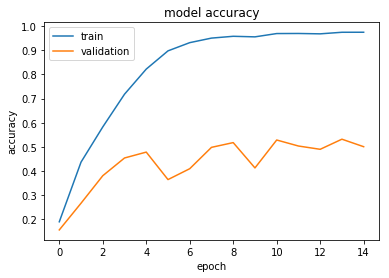

In [8]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

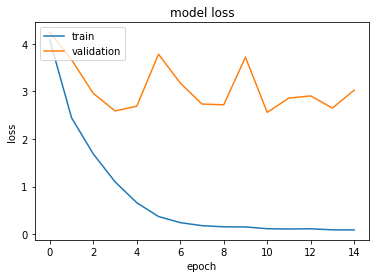

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
#Import test dataset
X_test = np.load('test_crop.npy')/255.
Y_test = np.load('onehot_y_test.npy')
y_test = np.load('test.npy')

In [11]:
##Convert label to onehot
#y_test = label2onehot(Y_test[:, 0], 256)
#np.save('onehot_y_test.npy', y_test)

In [12]:
densemodel.load_weights('ResNet50_transfer_crop.hdf5')

In [13]:
#evaluate
eva = densemodel.evaluate(X_test, y_test[:, 0], batch_size=32, verbose=1, sample_weight=None)
print()
print("Loss = " + str(eva[0]))
print("Test Accuracy = " + str(eva[1]))

5956/5956 [==============================] - 24s 4ms/step
()
Loss = 2.6026759256525596
Test Accuracy = 0.5399597044996642


This image is: diamond-ring
The dict_label of image is: 54


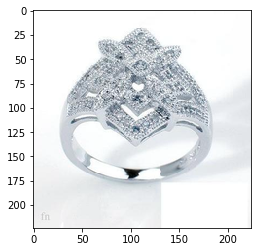

In [14]:
#predict a new image
predict_num = 1111
dict_label = label_dict()
X_predict = X_test[predict_num]
print('This image is: ' + dict_label[y_test[:, 0][predict_num]+1])
print('The dict_label of image is: '+str(y_test[:, 0][predict_num]+1))
plt.imshow(X_predict)

In [15]:
#predict
predict_vector = densemodel.predict(np.expand_dims(X_predict, axis=0))
index = np.where(predict_vector[0] == np.max(predict_vector[0]))
print('The predict dict_label of image is: '+str(index[0][0]+1))
print('The predict probability of image is: '+str(predict_vector[0, index[0][0]]))
print('This image is: ' + dict_label[index[0][0] + 1])

The predict dict_label of image is: 54
The predict probability of image is: 0.99430144
This image is: diamond-ring
